In [21]:
import importlib.util
spec = importlib.util.spec_from_file_location("BoundaryLayerToolbox", "/Users/claudiopierard/vc/BoundaryLayerToolbox.py")
blt = importlib.util.module_from_spec(spec)
spec.loader.exec_module(blt)

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy as spy
import scipy.io as sio
import scipy.optimize as optimization
import scipy.interpolate as interpolate
from netCDF4 import Dataset
import os

from IPython import display
from matplotlib import animation
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib.pyplot import cm 

In [4]:
estados_path = "/Users/claudiopierard/vc/datos/EstadosMX/"
estados_names = blt.nombres_estados
estados = {}
for i in estados_names:
    reg = blt.region()
    path = estados_path + i + ".xy"
    blt.read_region(reg, path)
    estados[i] = reg

In [5]:
file = '/Volumes/BUFFALO_SOLDIER/datos_WRF/04/coef/Cl_wrfout_d02_2015-04-05_00.nc'

path_to_wrf_month = "/Volumes/BUFFALO_SOLDIER/datos_WRF/04/coef/"
delegaciones_path = "/Users/claudiopierard/vc/datos/delegaciones_cdmx/"
estados_path = "/Users/claudiopierard/vc/datos/EstadosMX/"
domain = Dataset(file, 'r')

In [6]:
numero_dias = len(os.listdir(path_to_wrf_month))

In [7]:
nx = 51*2
ny = 64*2

In [8]:
domain_the_first = Dataset(path_to_wrf_month + 'Cl_wrfout_d02_2015-04-02_00.nc', 'r')
xlat = domain_the_first.variables['XLAT'] #sólo quiero declararlas 1 vez.
xlong = domain_the_first.variables['XLONG']
hgt = domain_the_first.variables['HGT']
        
x_range = np.linspace(xlong[0, :, 0].min(), xlong[0,0, :].max(), nx)
y_range = np.linspace(xlat[0, 0, :].min(), xlat[0,:, 0].max(), ny)
new_xlong, new_xlat = np.meshgrid(x_range, y_range, indexing='ij')
new_xlong.shape

vc_month_24 = np.zeros((numero_dias, 24, new_xlong.shape[0], new_xlong.shape[1])) 
vc_month_48 = np.zeros((numero_dias, 24, new_xlong.shape[0], new_xlong.shape[1])) 

pblh_24 = np.zeros((numero_dias, 24, new_xlong.shape[0], new_xlong.shape[1])) 
pblh_48 = np.zeros((numero_dias, 24, new_xlong.shape[0], new_xlong.shape[1])) 

u_mean_24 = np.zeros((numero_dias, 24, new_xlong.shape[0], new_xlong.shape[1])) 
u_mean_48 = np.zeros((numero_dias, 24, new_xlong.shape[0], new_xlong.shape[1])) 

In [9]:
x_range = np.linspace(xlong[0, :, 0].min(), xlong[0,0, :].max(), nx)
y_range = np.linspace(xlat[0, 0, :].min(), xlat[0,:, 0].max(), ny)

In [10]:
new_xlong, new_xlat = np.meshgrid(x_range, y_range, indexing='ij')

In [11]:
date_list = []
for name in os.listdir(path_to_wrf_month):
    i_beg = name.find('2015')
    i_end = name.find('_00')
    date_list.append(name[i_beg:i_end])
date_list = np.array(date_list)
    

In [12]:
date_list = []
for i,name in enumerate(os.listdir(path_to_wrf_month)):
        
    i_beg = name.find('2015')
    i_end = name.find('_00')
    date_list.append(name[i_beg:i_end])
    
    file = path_to_wrf_month + name
    domain = Dataset(file, 'r')
    
    u = domain.variables['Ua']
    v = domain.variables['Va']
    pblh = domain.variables['PBLH']
    ph = domain.variables['PH']
    phb = domain.variables['PHB']
        
    z = blt.compute_height(ph, phb)
    vc = blt.ventilation_coefficient(u[:], v[:], pblh[:], hgt[:], z[:])
    u_mean = blt.U_mean_PBL(u[:], v[:], pblh[:], hgt[:], z[:])

    new_vc = blt.interpolate_field(x_range, y_range, xlong, xlat, vc)
    new_pblh = blt.interpolate_field(x_range, y_range, xlong, xlat, pblh)
    new_u_mean = blt.interpolate_field(x_range, y_range, xlong, xlat, u_mean)
    
    vc_month_24[i,:,:,:] = new_vc[6:30, :, :]
    vc_month_48[i,:,:,:] = new_vc[30:, :, :]
    
    pblh_24[i,:,:,:] = new_pblh[6:30, :, :]
    pblh_48[i,:,:,:] = new_pblh[30:, :, :]
    #pblh_2days[i,:,:,:] = new_vc
    u_mean_24[i,:,:,:] = new_u_mean[6:30, :, :]
    u_mean_48[i,:,:,:] = new_u_mean[30:, :, :]
    
date_list = np.array(date_list)

In [54]:
date_list = list(date_list)

In [55]:
asciiDateList = [n.encode("ascii", "ignore") for n in date_list]

In [ ]:
date_list

In [13]:
vc_month_24.shape

(29, 24, 102, 128)

In [14]:
vc_month_48.shape

(29, 24, 102, 128)

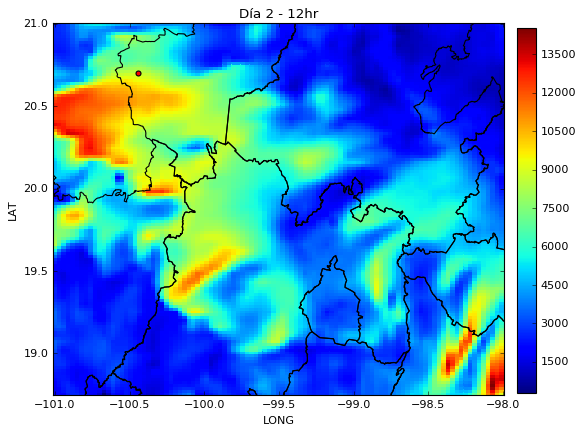

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlim(xlong[0,0,:].min(), xlong[0,0,:].max())
ax.set_ylim(xlat[0,:,0].min(), xlat[0,:,0].max())

d = 2
t = 12

im = ax.pcolormesh(new_xlong, new_xlat, vc_month_24[d, t,:,:])
ax.scatter(new_xlong[xx,yy], new_xlat[xx,yy], c = 'r')

for name in estados_names:
    ax.plot(estados[name].lon, estados[name].lat, c='k')

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.76])
fig.colorbar(im, cax=cbar_ax)

ax.set_xlabel('LONG')
ax.set_ylabel('LAT')
ax.set_title('Día ' + str(d) +' - ' + str(t) + 'hr')

In [27]:
pblh_24.shape

(29, 24, 102, 128)

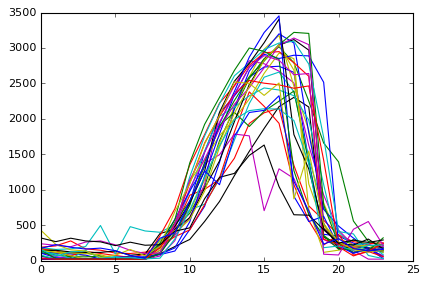

In [29]:
for i in range(0, len(pblh_24[:,0,0,0])):
    plt.plot(pblh_24[i,:,xx,yy])

In [18]:
xlat_jqro, xlong_jqro = 20.7030, -100.4473

In [20]:
new_xlong.shape

(102, 128)

In [23]:
xx, yy = blt.near_coord_loc(new_xlong, new_xlat, xlong_jqro, xlat_jqro)

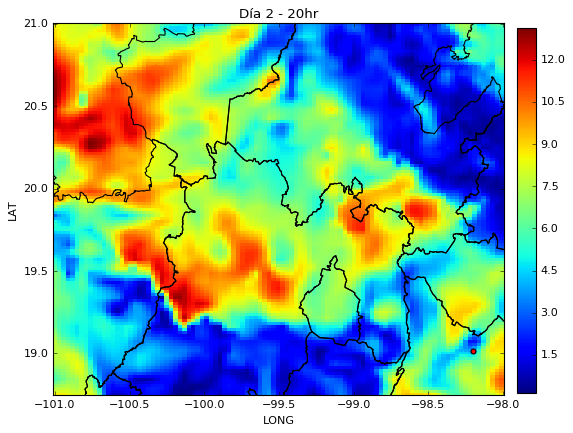

In [39]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlim(xlong[0,0,:].min(), xlong[0,0,:].max())
ax.set_ylim(xlat[0,:,0].min(), xlat[0,:,0].max())

d = 2
t = 20

im = ax.pcolormesh(new_xlong, new_xlat, u_mean_24[d, t,:,:]) 
ax.scatter(-98.198993, 19.012326, c = 'r')

for name in estados_names:
    ax.plot(estados[name].lon, estados[name].lat, c='k')

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.76])
fig.colorbar(im, cax=cbar_ax)

ax.set_xlabel('LONG')
ax.set_ylabel('LAT')
ax.set_title('Día ' + str(d) +' - ' + str(t) + 'hr')

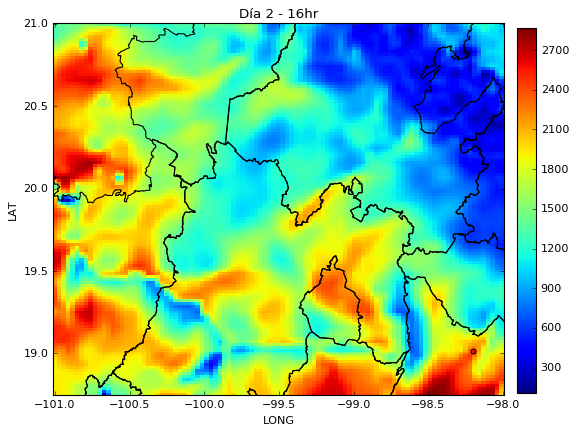

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlim(xlong[0,0,:].min(), xlong[0,0,:].max())
ax.set_ylim(xlat[0,:,0].min(), xlat[0,:,0].max())

d = 2
t = 16

im = ax.pcolormesh(new_xlong, new_xlat, pblh_24[d, t,:,:]) 
ax.scatter(-98.198993, 19.012326, c = 'r')

for name in estados_names:
    ax.plot(estados[name].lon, estados[name].lat, c='k')

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.76])
fig.colorbar(im, cax=cbar_ax)

ax.set_xlabel('LONG')
ax.set_ylabel('LAT')
ax.set_title('Día ' + str(d) +' - ' + str(t) + 'hr')

In [43]:
vc_month_24.shape

(29, 24, 102, 128)

In [44]:
vc_24_average = np.zeros_like(vc_month_24[0,:,:,:])
vc_48_average = np.zeros_like(vc_month_48[0,:,:,:])
vc_24_std = np.zeros_like(vc_month_24[0,:,:,:])
vc_48_std = np.zeros_like(vc_month_48[0,:,:,:])

vc_24_domain_avg = np.zeros(24)
vc_48_domain_avg = np.zeros(24)
vc_24_domain_std = np.zeros(24)
vc_48_domain_std = np.zeros(24)


dd,tt,ix,iy = vc_month_24.shape

for t in range(0, tt):
    for i in range(0, ix):
        for j in range(0,iy):
            vc_24_average[t,i,j] = np.mean(vc_month_24[:,t,i,j])
            vc_24_std[t,i,j] = np.std(vc_month_24[:,t,i,j])
            vc_48_average[t,i,j] = np.mean(vc_month_48[:,t,i,j])
            vc_48_std[t,i,j] = np.std(vc_month_48[:,t,i,j])
    vc_24_domain_avg[t] = np.mean(vc_24_average[t,:,:])
    vc_48_domain_avg[t] = np.mean(vc_48_average[t,:,:])
    vc_24_domain_std[t] = np.std(vc_24_average[t,:,:])
    vc_48_domain_std[t] = np.std(vc_48_average[t,:,:])


In [45]:
    for i in range(0, ix):
        for j in range(0,iy):
            vc_24_domain_avg[t,i,j] = np.mean(vc_24_average[:,i,j])
            vc_48_domain_avg[t,i,j] = np.mean(vc_month_48[:,t,i,j])

IndexError: too many indices for array

In [46]:
vc_24_std[12,4,30]

1180.3287241811693

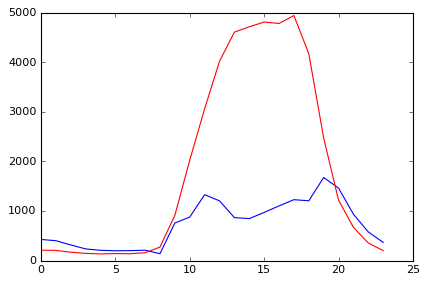

In [108]:
plt.plot(vc_24_std[:,30,30], c='b')
plt.plot(vc_24_average[:,30,30], c='r')

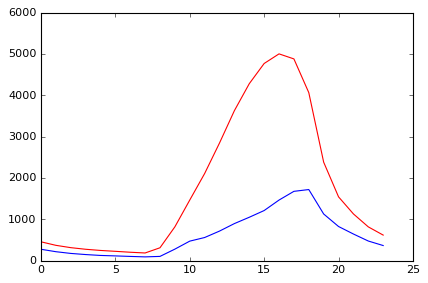

In [110]:
plt.plot(vc_24_domain_std, c='b')
plt.plot(vc_24_domain_avg, c='r')

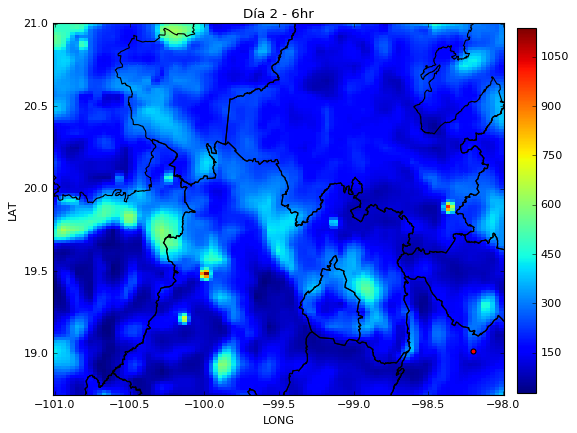

In [94]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(xlong[0,0,:].min(), xlong[0,0,:].max())
ax.set_ylim(xlat[0,:,0].min(), xlat[0,:,0].max())

d = 2
t = 6

im = ax.pcolormesh(new_xlong, new_xlat, vc_24_average[t,:,:]) #pblh[18,:,:])
ax.scatter(-98.198993, 19.012326, c = 'r')

for name in estados_names:
    ax.plot(estados[name].lon, estados[name].lat, c='k')

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.76])
fig.colorbar(im, cax=cbar_ax)

ax.set_xlabel('LONG')
ax.set_ylabel('LAT')
ax.set_title('Día ' + str(d) +' - ' + str(t) + 'hr')

# Guardando un archivo

In [47]:
import h5py

In [50]:
path_2_datos_vc = "/Volumes/BUFFALO_SOLDIER/datos_VC/"

In [56]:
with h5py.File('april_24.h5', 'w') as hdf:
    hdf.create_dataset('vc_24h', data=vc_month_24, dtype='int')
    hdf.create_dataset('u_mean_24h', data=u_mean_24)
    hdf.create_dataset('pblh_24h', data=pblh_24)
    hdf.create_dataset('dates_24', (len(asciiList),1),'S10', asciiList)

In [74]:
type(np.array(date_list)[0])

numpy.str_

In [62]:
with h5py.File('april_24.h5', 'r') as hdf:
    ls = list(hdf.keys())
    print('List of dataset in file:', ls)
    datess = hdf.get('dates_24')
    dataset = np.array(datess)

List of dataset in file: ['dates_24', 'pblh_24h', 'u_mean_24h', 'vc_24h']


In [63]:
dataset

array([[b'2015-04-02'],
       [b'2015-04-03'],
       [b'2015-04-04'],
       [b'2015-04-05'],
       [b'2015-04-06'],
       [b'2015-04-07'],
       [b'2015-04-08'],
       [b'2015-04-09'],
       [b'2015-04-10'],
       [b'2015-04-11'],
       [b'2015-04-12'],
       [b'2015-04-13'],
       [b'2015-04-14'],
       [b'2015-04-15'],
       [b'2015-04-16'],
       [b'2015-04-17'],
       [b'2015-04-18'],
       [b'2015-04-19'],
       [b'2015-04-20'],
       [b'2015-04-21'],
       [b'2015-04-22'],
       [b'2015-04-23'],
       [b'2015-04-24'],
       [b'2015-04-25'],
       [b'2015-04-26'],
       [b'2015-04-27'],
       [b'2015-04-28'],
       [b'2015-04-29'],
       [b'2015-04-30']], 
      dtype='|S10')